In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
reddit = pd.read_csv("Reddit_Combi.csv", sep=';')
reddit.drop(['Unnamed: 4'], axis=1, inplace=True)
reddit.head()

,title,body,Body_Title,label
0,Envy to other is swallowing me,"Im from developingcountry, Indonesia , and for...",Envy to other is swallowing me Im from develop...,1
1,Nothin outta the ordinary. Paradise. Job stres...,Um hello ....well many can relate im sure. Aft...,Nothin outta the ordinary. Paradise. Job stres...,1
2,Almost 49 and the chasm of emptiness has never...,I’ve been diagnosed severe bi polar where you ...,Almost 49 and the chasm of emptiness has never...,1
3,I’m happy again,"After my closest friend left me in April, I ha...",I’m happy again After my closest friend left m...,0
4,Is it possible to recover from such a traumati...,"I am only 15, and yet I feel my life is alread...",Is it possible to recover from such a traumati...,1


In [6]:
print(reddit.shape)
reddit.isnull().sum()

(3123, 4)


title          0
body          10
Body_Title     0
label          0
dtype: int64

In [7]:
twitter = pd.read_csv("Twitter_ Non-Advert-Tabelle 1.csv", sep=';')
twitter.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
twitter.head()

,text,label
0,speak-no-evil monkey Can I Be Honest With You...,1
1,Frau Goebbels early signs of psychosis psychot...,1
2,A lot of work and unfulfilled tasks plunge you...,1
3,Private health insurance delivers value for yo...,1
4,XpertOnline offers you the convenience of view...,1


In [8]:
print(twitter.shape)
twitter.isnull().sum()

(2051, 2)


text     0
label    0
dtype: int64

In [9]:
df = pd.DataFrame({
    'text': np.append(reddit['Body_Title'], twitter['text']),
    'label': np.append(reddit['label'], twitter['label'])
})
df.head()

,text,label
0,Envy to other is swallowing me Im from develop...,1
1,Nothin outta the ordinary. Paradise. Job stres...,1
2,Almost 49 and the chasm of emptiness has never...,1
3,I’m happy again After my closest friend left m...,0
4,Is it possible to recover from such a traumati...,1


In [10]:
print(df.shape)
df.isnull().sum()

(5174, 2)


text     0
label    0
dtype: int64

In [11]:
df.duplicated().sum()

79

In [12]:
df.drop_duplicates(keep="first", inplace=True)
df.shape

(5095, 2)

<Axes: ylabel='len'>

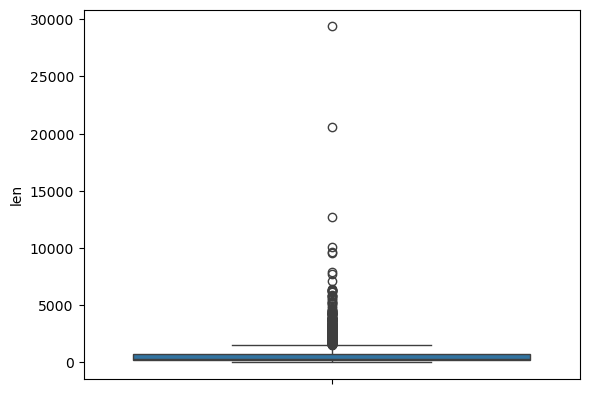

In [15]:
df['len'] = df['text'].apply(len)
sns.boxplot(df['len'])

# Preprocessing and Sentiment Analysis

In [16]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns

In [17]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")


c:\Users\Nico\anaconda3\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Nico\anaconda3\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nico\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer M

In [22]:
def txt_transform(text):
    text = text.lower()

    # Tokenize input text for BERT
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Perform sentiment analysis with BERT
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        sentiment = torch.softmax(logits, dim=1).cpu().numpy()

    # Return sentiment analysis results
    return {
        "negative": sentiment[0][0],
        "neutral": sentiment[0][1],
        "positive": sentiment[0][2]
    }

In [24]:
df['out']= df['text'].apply(txt_transform)

In [26]:
df['neg'] = df['out'].apply(lambda x:x['negative'])
df['neu'] = df['out'].apply(lambda x:x['neutral'])
df['pos'] = df['out'].apply(lambda x:x['positive'])

<Axes: >

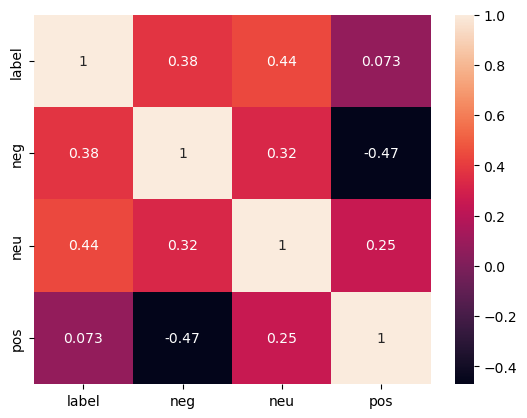

In [37]:
sns.heatmap(df[['label','neg','neu','pos']].corr(), annot=True)

# Model Creation

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

model = SVC()

In [45]:
xdata = df[['pos','neu', 'neg']]
ydata = df['label']

xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, train_size=0.7)

In [46]:
model.fit(xtrain, ytrain)
pred = model.predict(xtest)

In [47]:
print(metrics.classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.62      0.42      0.50       331
           1       0.85      0.93      0.89      1198

    accuracy                           0.82      1529
   macro avg       0.74      0.67      0.69      1529
weighted avg       0.80      0.82      0.81      1529



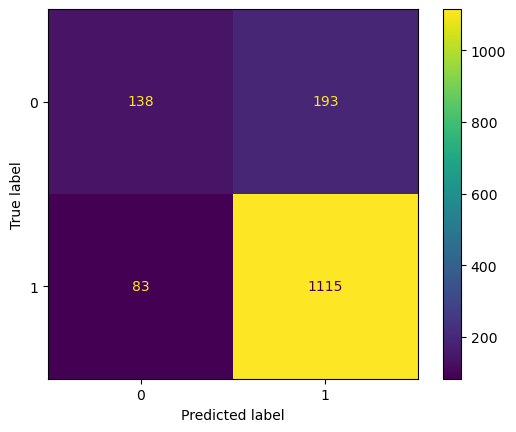

In [48]:
cm = metrics.confusion_matrix(ytest, pred)
fig = metrics.ConfusionMatrixDisplay(cm)
fig.plot()